In [1]:
import numpy as np
import matplotlib.pyplot as plt
import linelist as ls
from scipy.optimize import curve_fit
from scipy.special import wofz
# from lmfit.models import VoigtModel
import astropy.units as u
from scipy.signal import savgol_filter

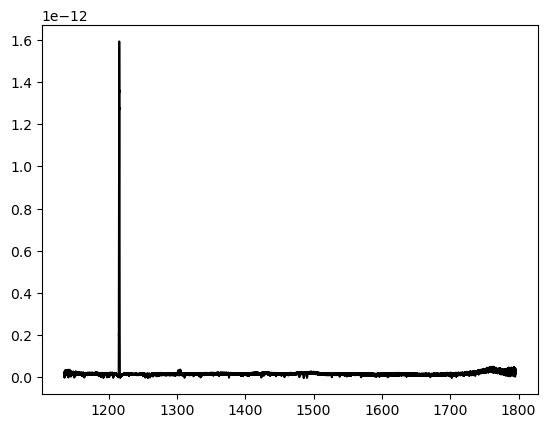

In [3]:
%matplotlib inline
wavelength, flux, error, continuum = np.loadtxt('data/spec_HE0153-4520_LA.dat', usecols=[0,1,2,3]).transpose()
normalised_flux = flux/continuum
c = 299792.458 # km/s
plt.plot(wavelength, flux, 'k-')
z = 0.45#5730/ls.find_line('Lya')[0]-1
# print('Redshift: ', z)
plt.show()

## Normalised flux

(1135.29231, 1795.20538)

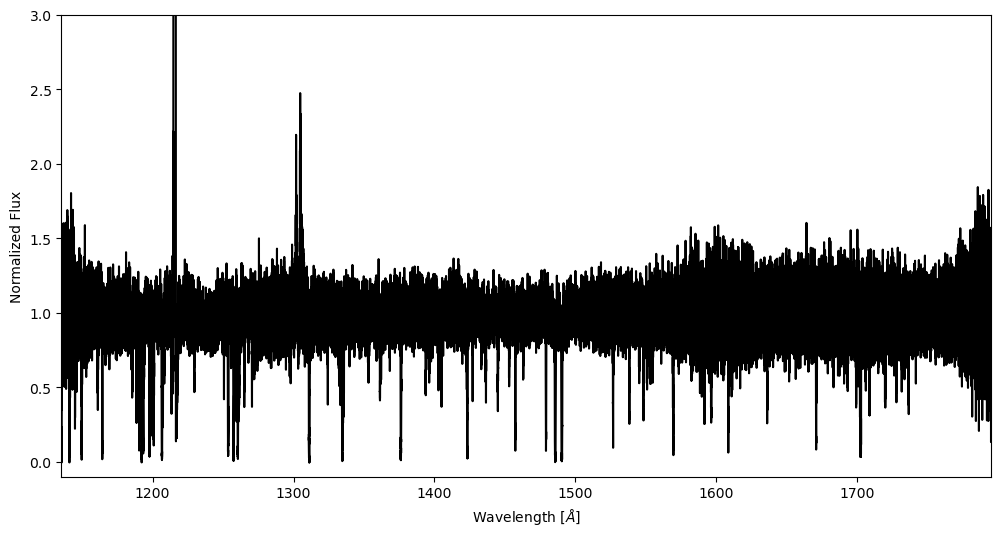

In [4]:
plt.figure(figsize=(12,6))
plt.plot(wavelength, normalised_flux, 'k-')
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Normalized Flux')
plt.ylim(-0.1, 3)
plt.xlim(wavelength[0], wavelength[-1])

In [5]:
# %matplotlib widget
def zoom(a, b=None, w=200):
    if b == None:
        b = a+w/2
        a -= w/2
    plt.plot(wavelength, normalised_flux, 'k-')
    plt.xlabel('Wavelength [$\AA$]')
    plt.ylabel('Normalized Flux')
    plt.xlim(a, b)

def velocity_space(wl, w=200):
    delta_wl = wavelength-wl
    v = c*delta_wl/wavelength
    plt.plot(v, normalised_flux, 'k-')
    plt.xlabel('Velocity [km s$^{-1}$]')
    plt.ylabel('Normalized Flux')
    plt.xlim(-w, w)
    return v

In [6]:
from scipy.ndimage import gaussian_filter1d

def voight(x, x0, sigma, gamma):
    return 1-np.real(wofz((x - x0 + 1j*gamma)/sigma/np.sqrt(2)))

def broaden(x, x0, sigma, gamma, kernel):
    return gaussian_filter1d(voight(x, x0, sigma, gamma), kernel)

In [7]:
def fit_profile(wl, w=150, p0=None):
    v = velocity_space(wl)
    roi = np.where((v < w) & (v > -w))
    xs, ys = v[roi], savgol_filter(normalised_flux, 25, 5)[roi]
    
    params, cov = curve_fit(broaden, xs, ys, p0=[0, 15, 1, np.mean(error_array[roi])], sigma=error_array[roi], absolute_sigma=True)
    fit_x = np.linspace(xs[0], xs[-1], 200)
    print(params)
    fit_y = broaden(fit_x, *params)

    # redo delta lambda
    v = velocity_space(params[1])
    plt.plot(fit_x, fit_y, 'r-')
    plt.plot(v, normalised_flux, 'k-', alpha=0.8)
    # plt.ylim(np.min(ys)-0.1, 1.05)
    plt.xlim(-w, w)
    # plt.show()

    errs = np.sqrt(np.diag(cov))
    b, berr = np.sqrt(2)*params[1], np.sqrt(2)*errs[1]
    return (b, berr), params[2]

error_array = error/continuum

In [8]:
def gaussian(x, A, mu, sigma): return 1-A*np.exp(-(x-mu)**2/(2*sigma**2))

def fit_gaussian(xs, ys, p0=None):
    popt, pcov = curve_fit(f=gaussian, xdata=xs, ydata=ys, p0=p0, maxfev=5000)
    xFit = np.arange(min(xs)-20,max(xs)+20, 2e-4)
    return xFit, gaussian(xFit, *popt), popt

# Search for lines

In [9]:
zabs = .22601
wls = ls.possible_lines(zabs, wavelength[0], wavelength[-1])
len(wls)

+------------+--------------+----------+-----------+
| Line       |   Wavelength |        f |     Gamma |
|------------+--------------+----------+-----------|
| HI_926     |      926.226 | 0.003183 | 8.255e+06 |
| DI_930     |      930.495 | 0.004817 | 1.237e+07 |
| HI_930     |      930.748 | 0.004814 | 1.236e+07 |
| SVI_933    |      933.378 | 0.437    | 1.67e+09  |
| DI_937     |      937.548 | 0.007808 | 2.45e+07  |
| HI_937     |      937.803 | 0.007799 | 2.45e+07  |
| Lye        |      937.803 | 0.007799 | 2.45e+07  |
| SVI_944    |      944.523 | 0.215    | 1.61e+09  |
| CI_945     |      945.188 | 0.2726   | 1e+08     |
| DI_949     |      949.485 | 0.01395  | 4.204e+07 |
| HI_949     |      949.743 | 0.01394  | 4.204e+07 |
| Lyd        |      949.743 | 0.01394  | 4.204e+07 |
| PIV_950    |      950.657 | 1.49     | 3.67e+09  |
| NI_953c    |      953.415 | 0.0129   | 2.19e+08  |
| NI_953b    |      953.655 | 0.0247   | 2.1e+08   |
| NI_953a    |      953.97  | 0.0331   | 2.03e

107

In [11]:
def show_line(wl_obs, window, in_velocity=True):
    roi = np.where((abs(wavelength-wl_obs) < window))
    xs = wavelength[roi]
    ys = normalised_flux[roi]
    try:
        xfit, yfit, params = fit_gaussian(xs, ys, p0=[np.min(ys), wl_obs, window])

        velocity_space(wl_obs, w=300)

        if params[0] > 0 and (xs[0] < params[1] < xs[-1]):
            plt.axvline(0, linestyle='--', linewidth=1, color='k')
            return True
            # if in_velocity:
                # plt.axvline(0, linestyle='--', linewidth=1, color='k')
    #             return True
        
    #         else:
    #             # plt.plot(xfit, yfit, 'r')
    #             plt.plot(xs, ys, 'k')
    #             plt.xlim(xs[0], xs[-1])
        
    #     else:
    #         plt.plot(xs, ys, 'k')
    #         plt.xlim(xs[0], xs[-1])
    except:
        velocity_space(wl_obs, w=300)
        # plt.plot(xs, ys, 'k')
        # plt.xlim(xs[0], xs[-1])

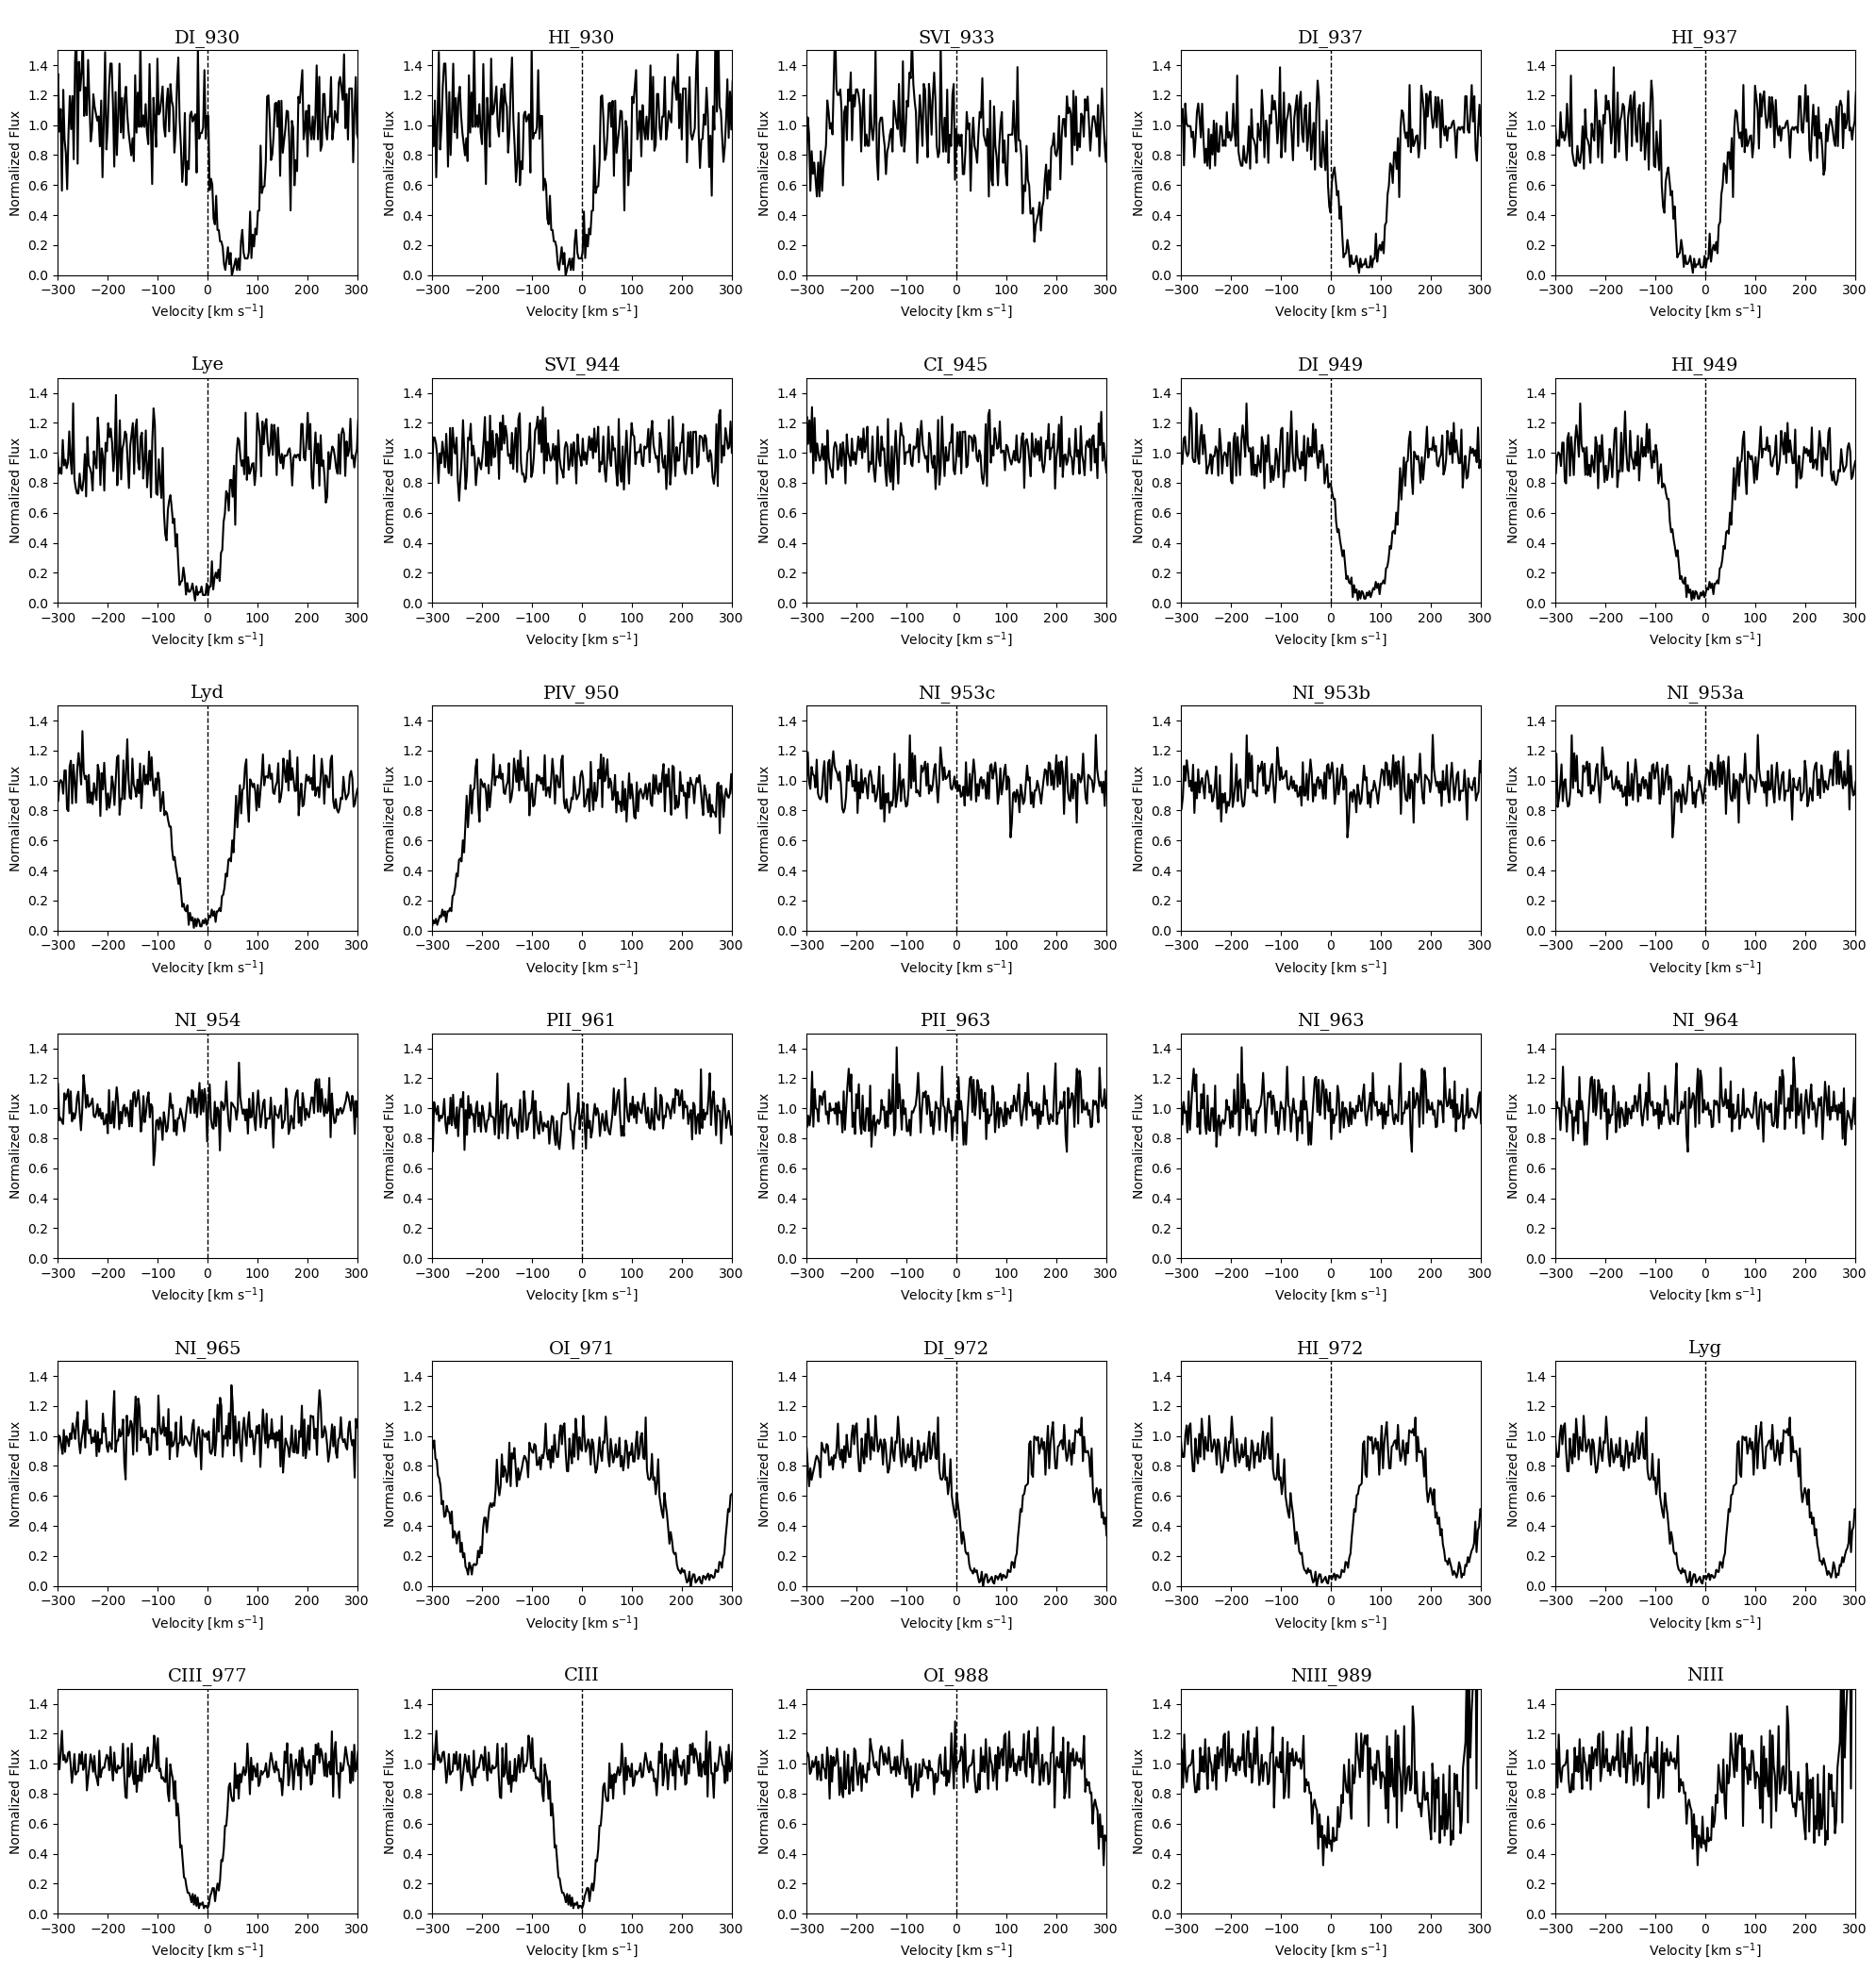

In [12]:
valid_lines = []
nrows, ncols = 6, 5
fig, axes = plt.subplots(nrows = nrows, ncols=ncols, figsize=(4*ncols, 3.5*nrows))

i = 1
for row in wls[1:31]:
    # Line, Wavelength, f, Gamma

    plt.subplot(nrows, ncols, i)
    wl_obs = row[1]*(1+zabs)
    window = 1
    if show_line(wl_obs, window):#, in_velocity=False):
        valid_lines.append(row)

    plt.title(f'\n{row[0]}',fontsize=14, fontdict={'family': 'serif'})
    plt.ylim(0, 1.5)
    i += 1

fig.tight_layout()
plt.show()

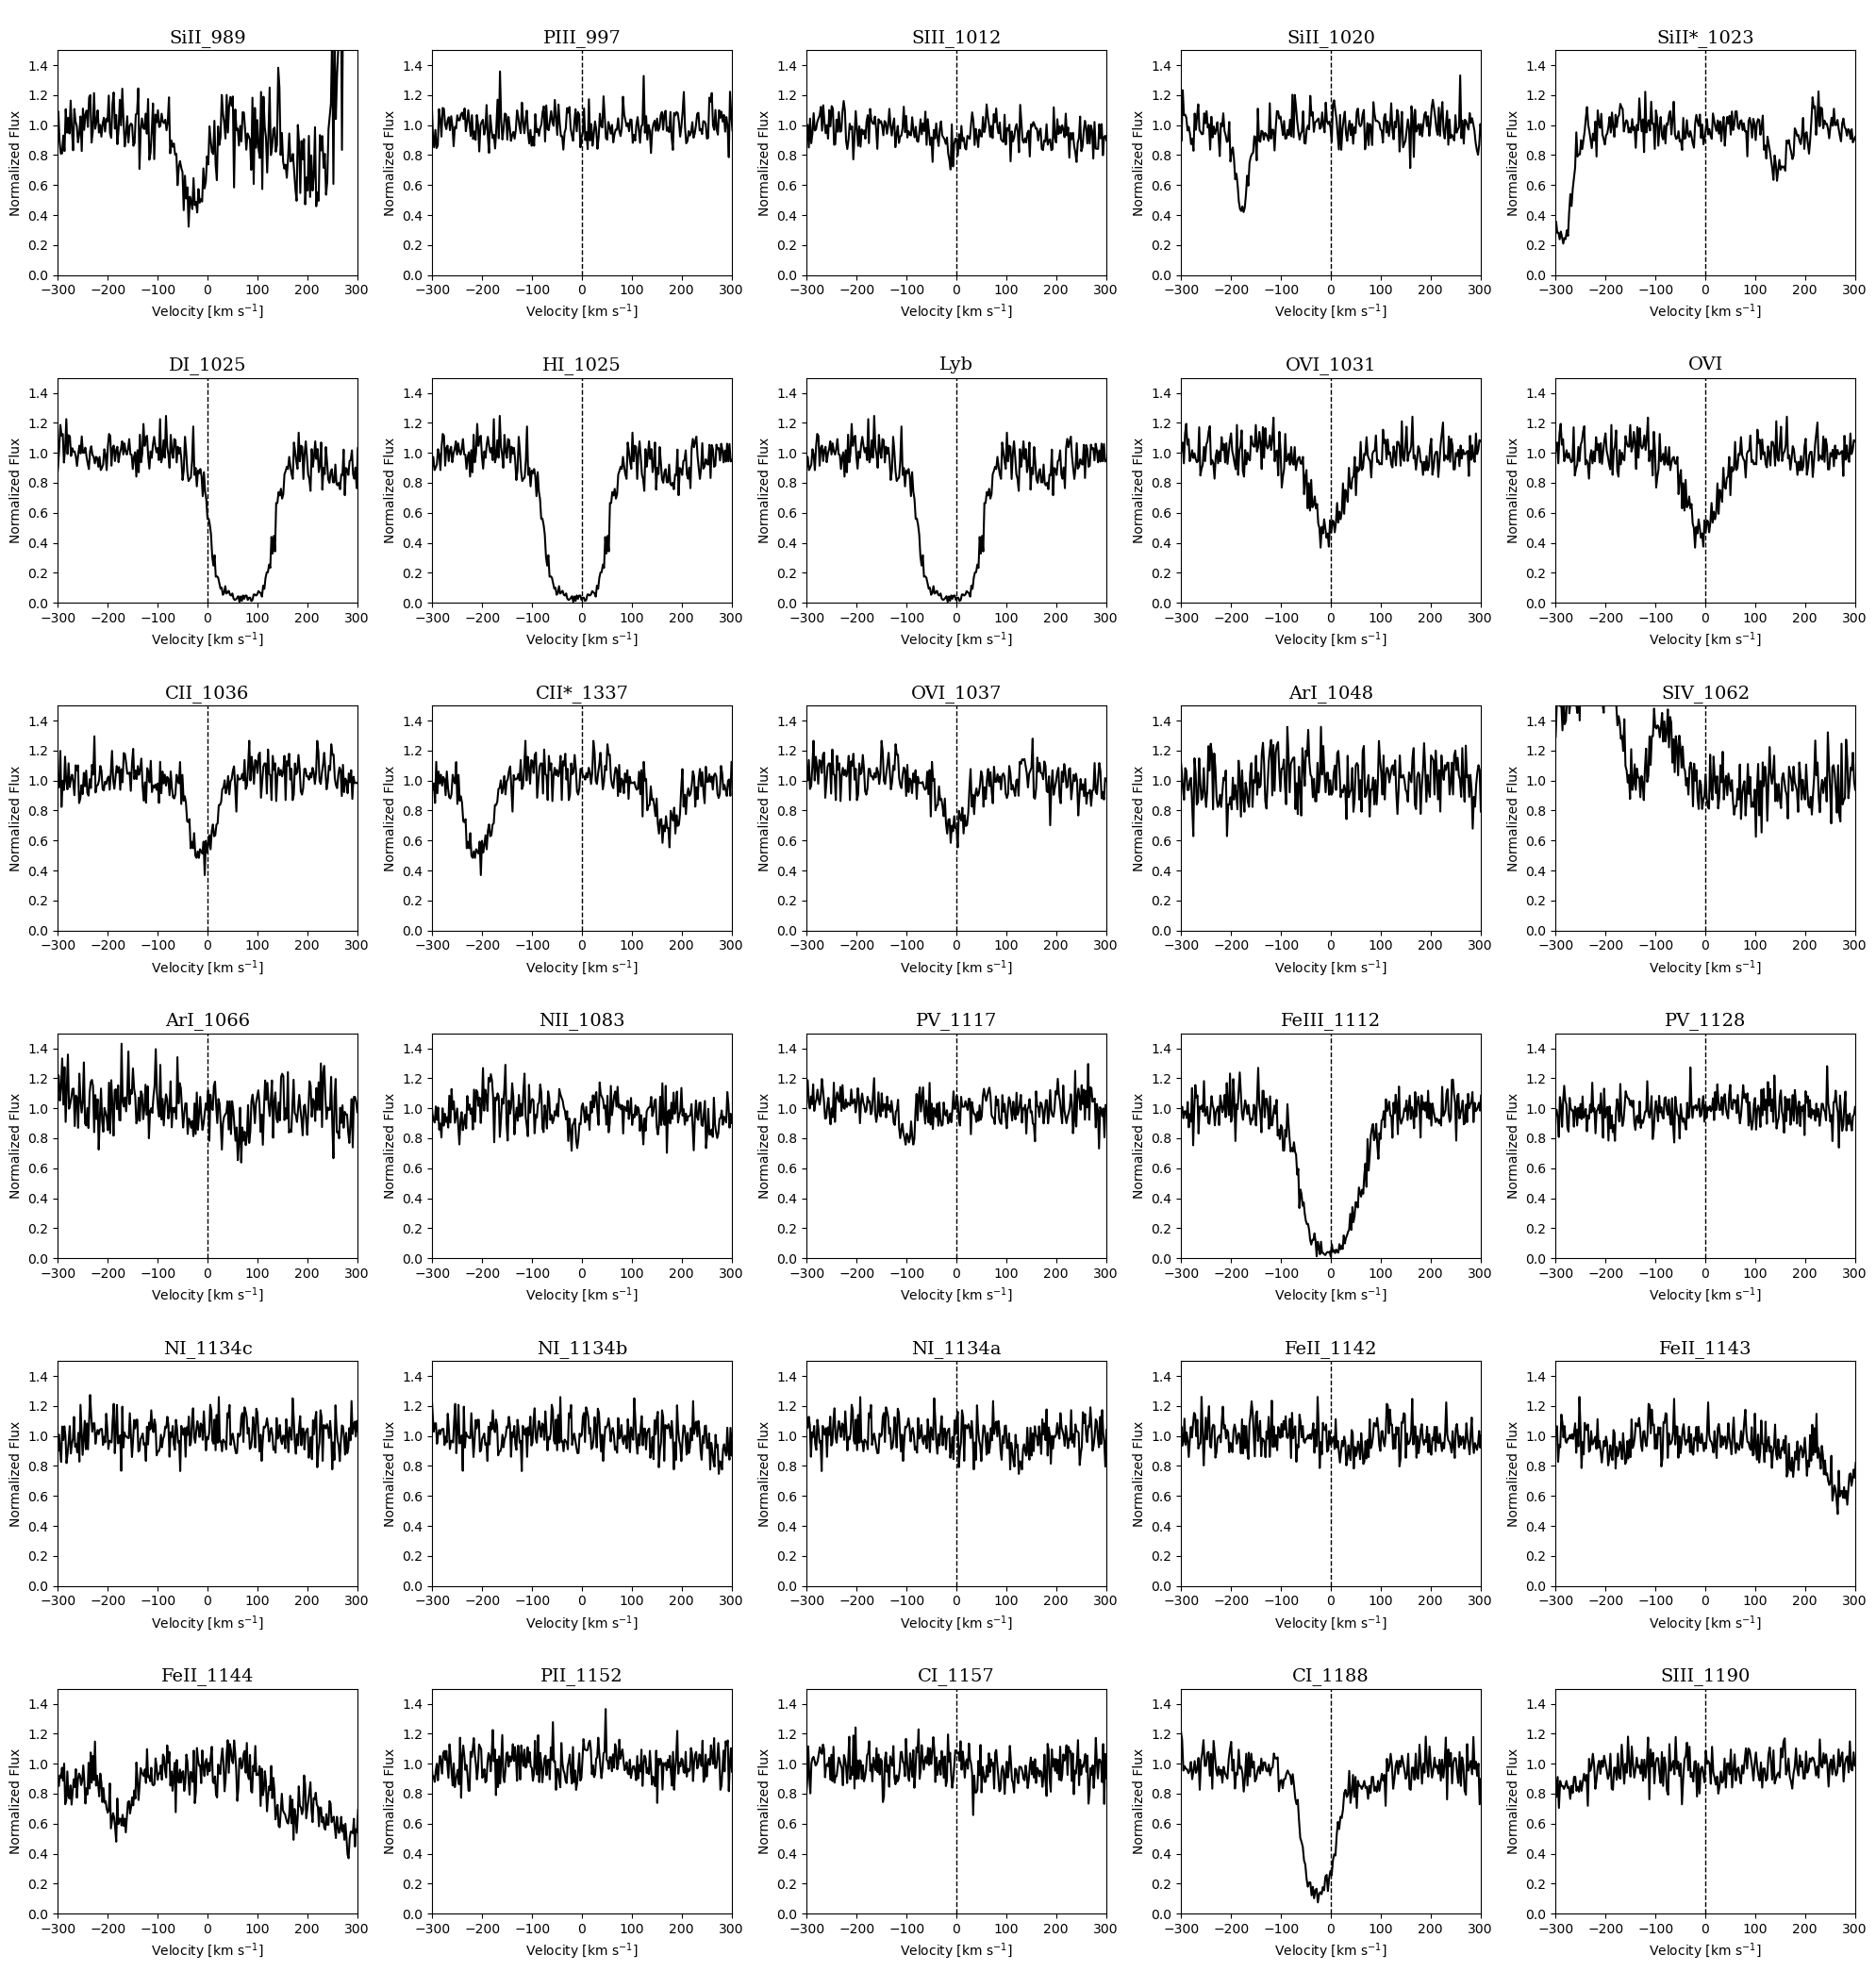

In [14]:
nrows, ncols = 6, 5
fig, axes = plt.subplots(nrows = nrows, ncols=ncols, figsize=(4*ncols, 3.5*nrows))

j = 1
for row in wls[31:61]:
    # Line, Wavelength, f, Gamma

    plt.subplot(nrows, ncols, j)
    wl_obs = row[1]*(1+zabs)
    window = 1
    if show_line(wl_obs, window):#, in_velocity=False):
        valid_lines.append(row)

    plt.title(f'\n{row[0]}',fontsize=14, fontdict={'family': 'serif'})
    plt.ylim(0, 1.5)
    j += 1

fig.tight_layout()
plt.show()

/home/gayatri/miniconda3/envs/tardis/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


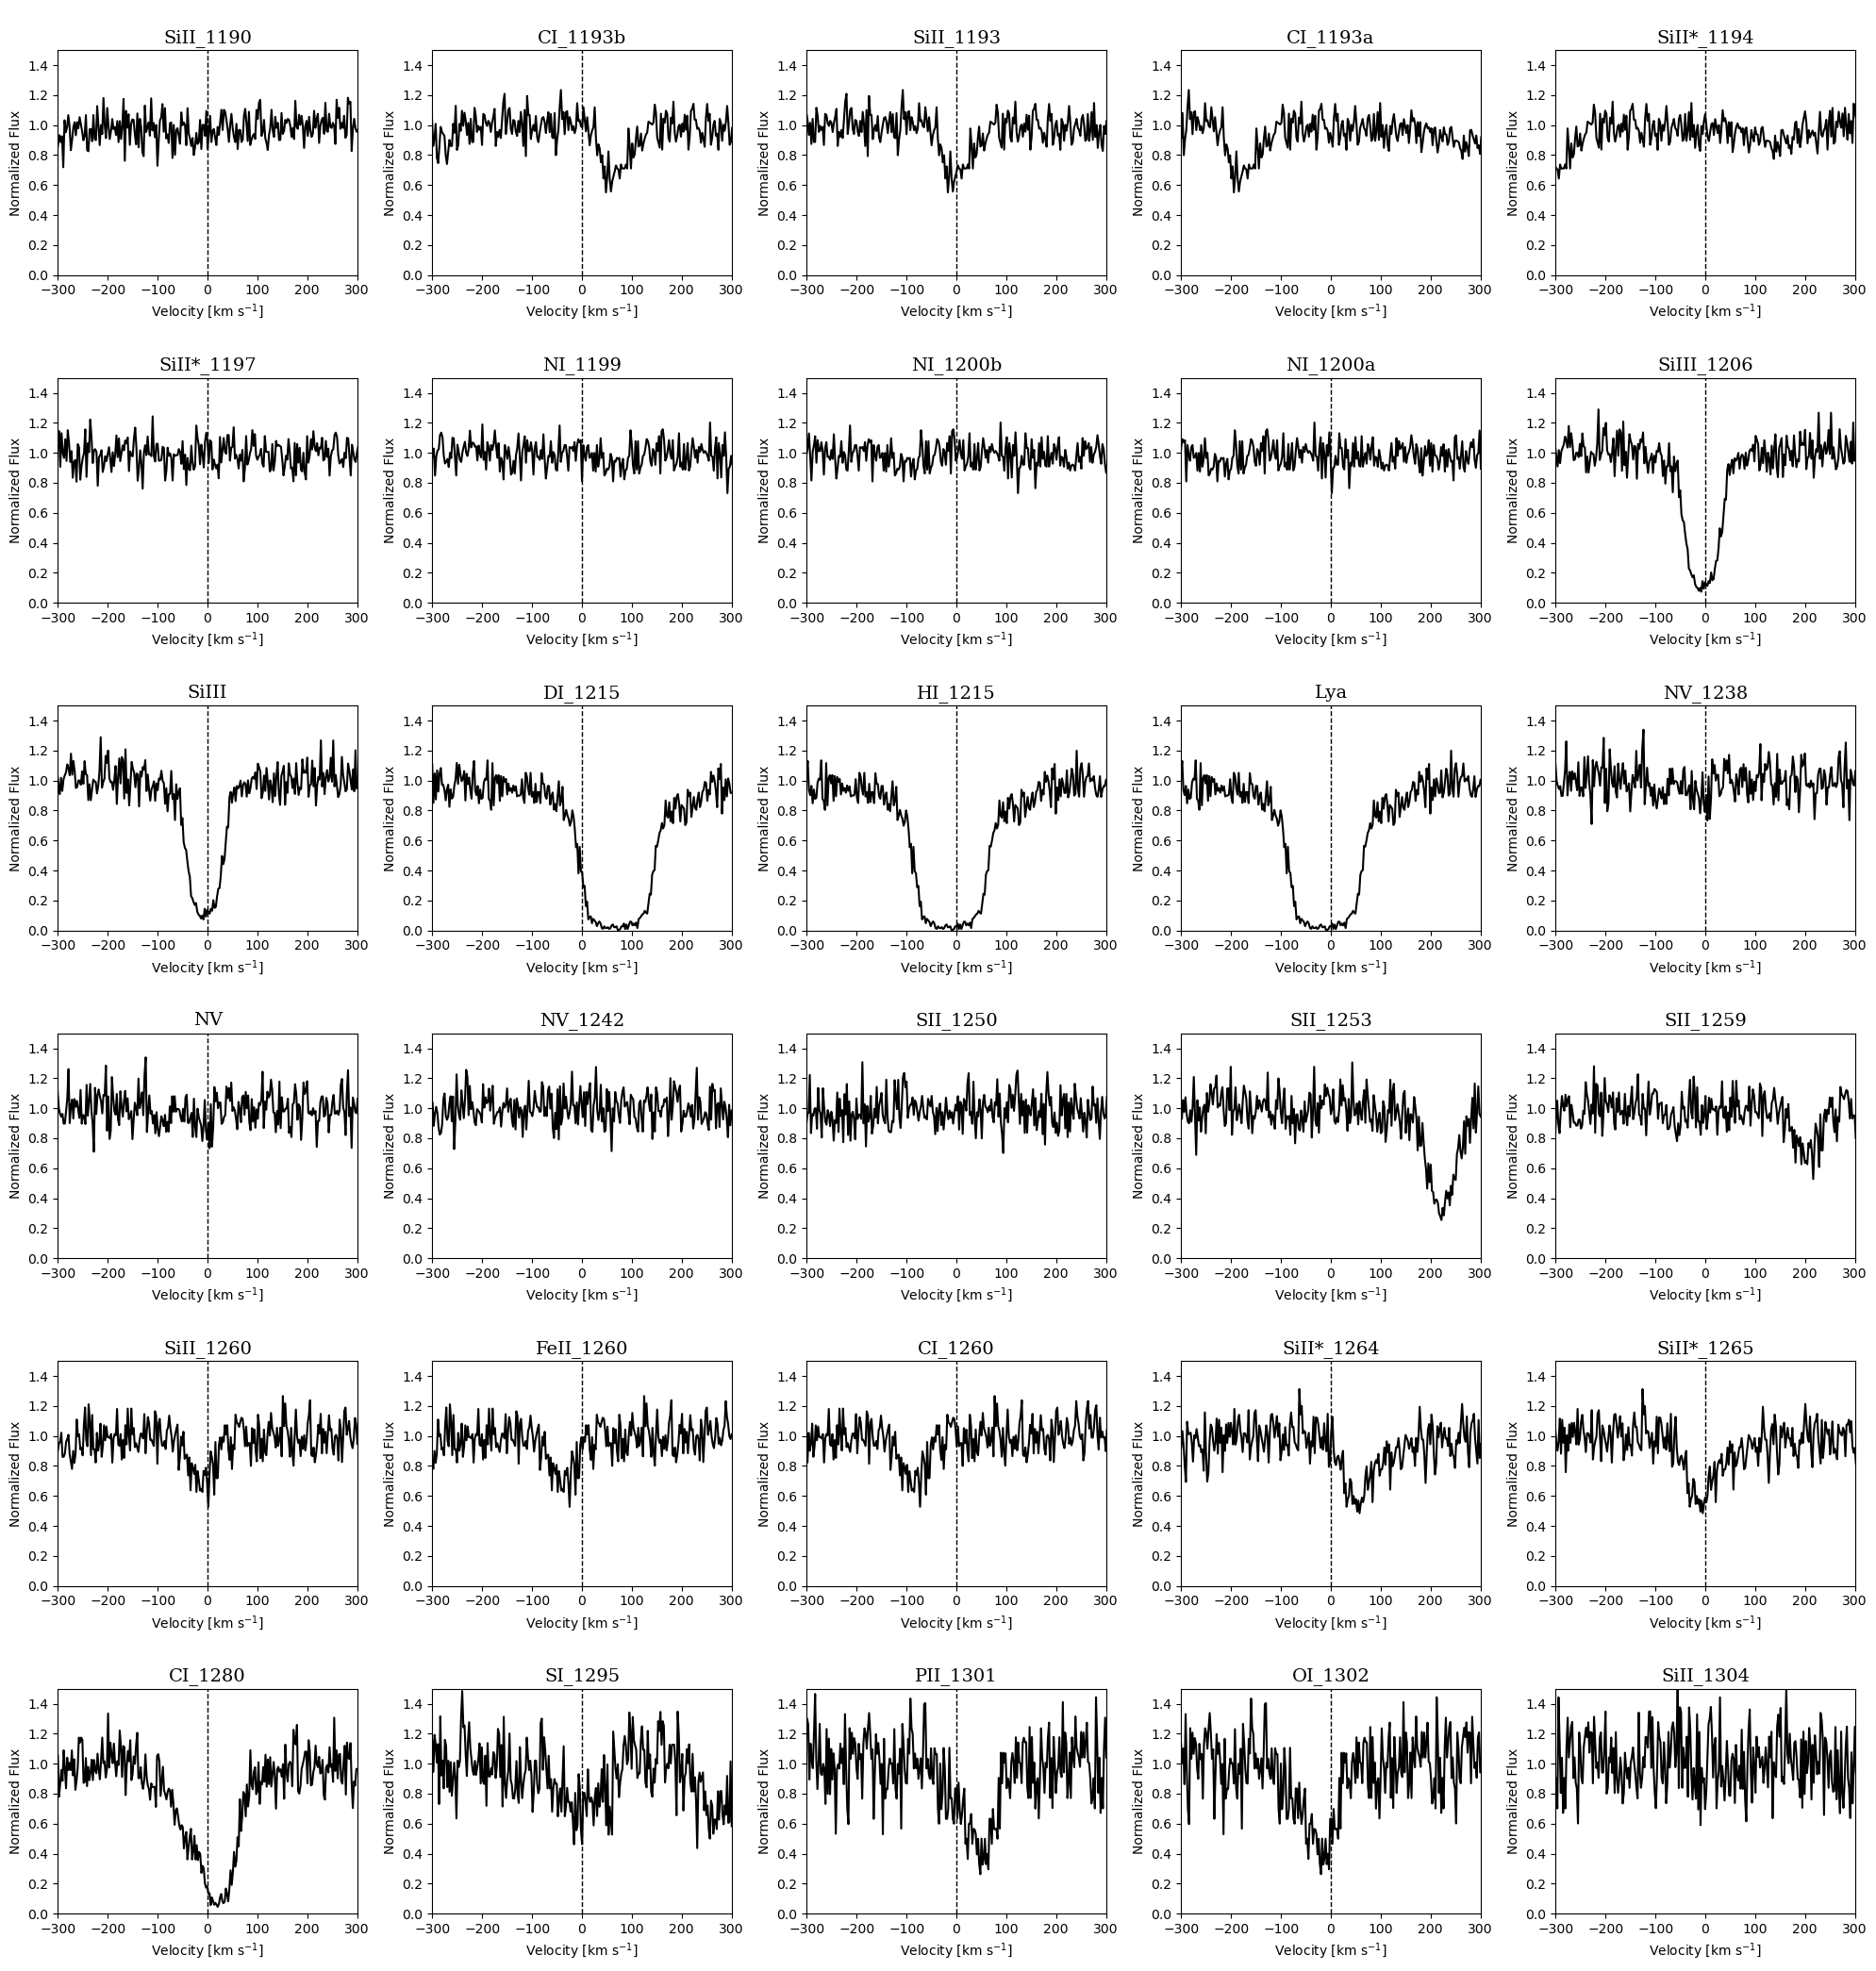

In [15]:
nrows, ncols = 6, 5
fig, axes = plt.subplots(nrows = nrows, ncols=ncols, figsize=(4*ncols, 3.5*nrows))

j = 1
for row in wls[61:91]:
    # Line, Wavelength, f, Gamma

    plt.subplot(nrows, ncols, j)
    wl_obs = row[1]*(1+zabs)
    window = 1
    if show_line(wl_obs, window):#, in_velocity=False):
        valid_lines.append(row)

    plt.title(f'\n{row[0]}',fontsize=14, fontdict={'family': 'serif'})
    plt.ylim(0, 1.5)
    j += 1

fig.tight_layout()
plt.show()

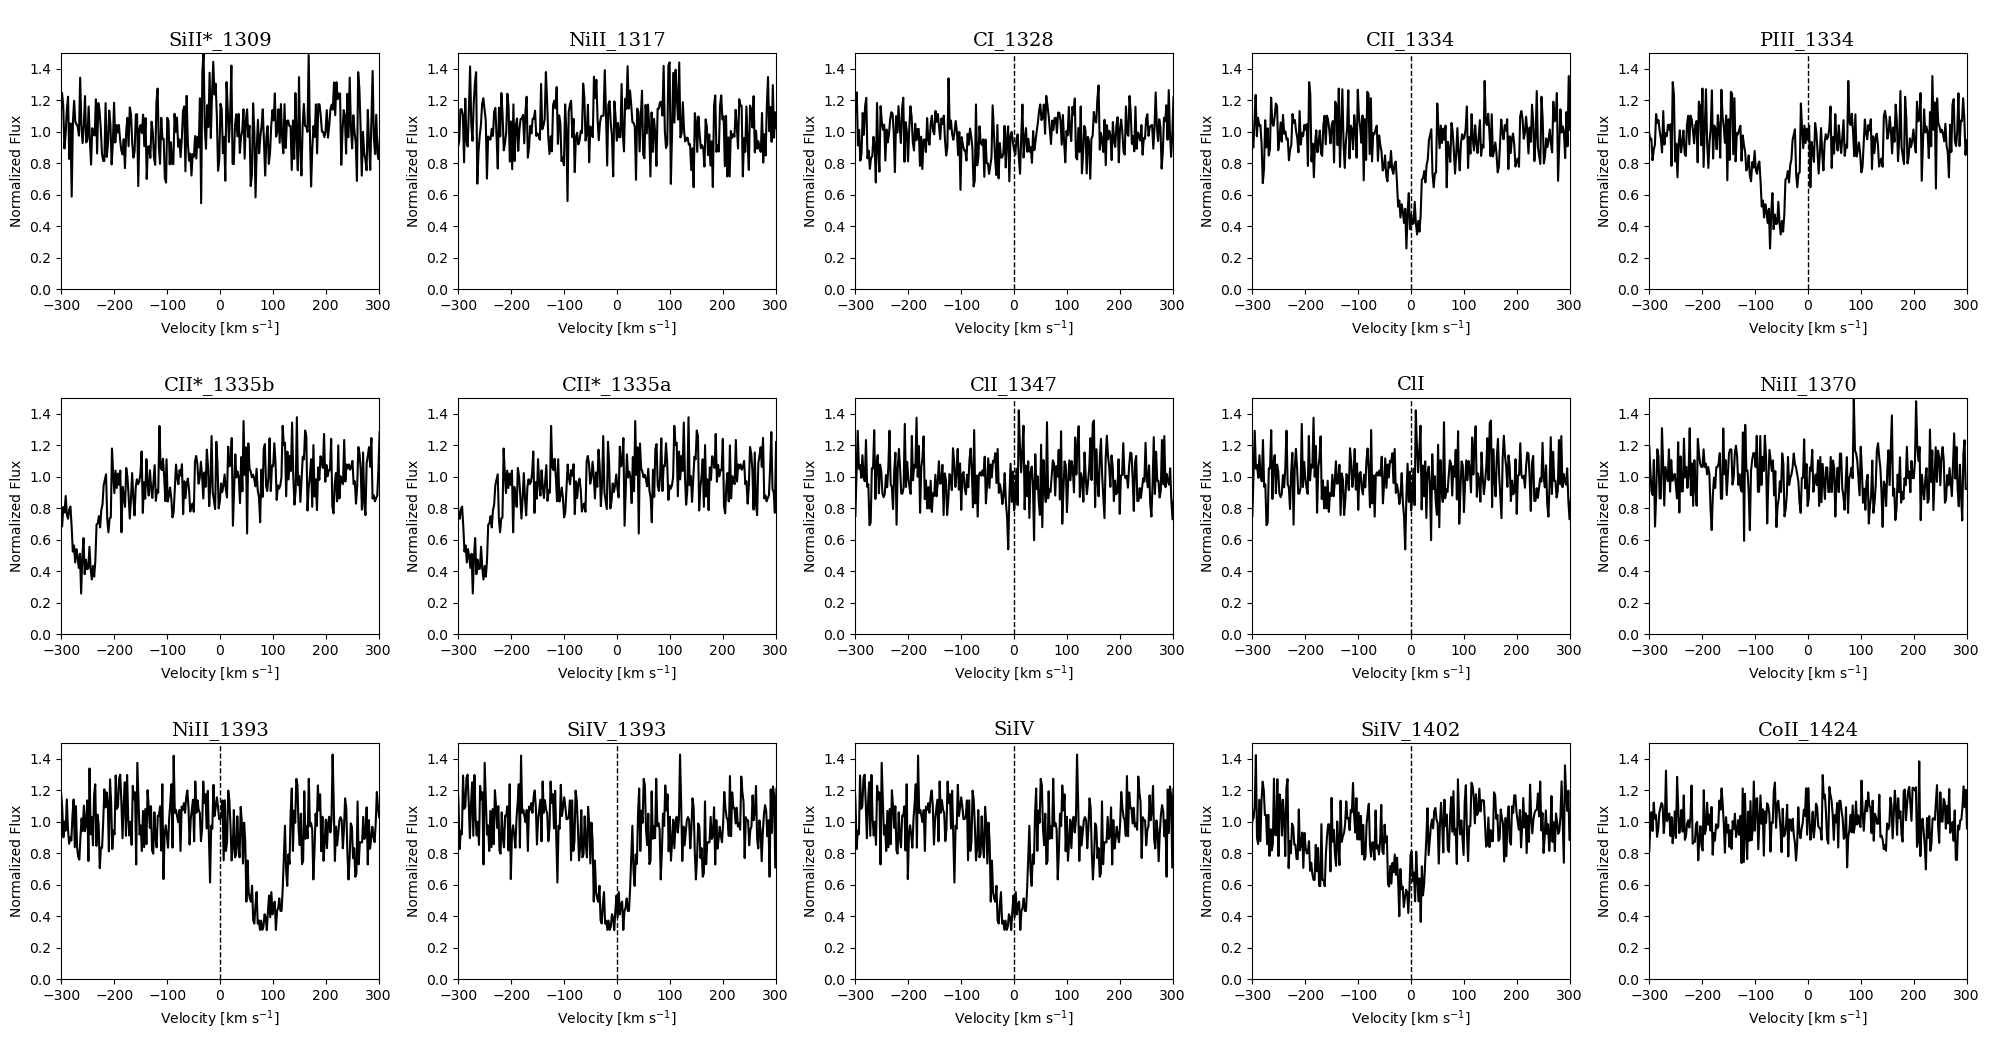

In [16]:
# fig, axes = plt.subplot()
nrows, ncols = 3, 5
fig, axes = plt.subplots(nrows = nrows, ncols=ncols, figsize=(4*ncols, 3.5*nrows))

j = 1
for row in wls[91:-1]:
    # Line, Wavelength, f, Gamma

    plt.subplot(nrows, ncols, j)
    wl_obs = row[1]*(1+zabs)
    window = 1
    if show_line(wl_obs, window):#, in_velocity=False):
        valid_lines.append(row)
        
    plt.title(f'\n{row[0]}',fontsize=14, fontdict={'family': 'serif'})

    plt.ylim(0, 1.5)
    j += 1

fig.tight_layout()
plt.show()

In [17]:
import pandas as pd
valid_lines_data = pd.DataFrame(valid_lines, columns=['Line', 'wl', 'f', 'gamma'])

In [21]:
invalid_lines = ['SVI_933', 'SiII_1020', 'SiII*_1023', 'CII*_1337', 'ArI_1066', 'PV_1117', 'ClI', 'ClI_1347', 'CI_1328', 'CI_1328', 'NV', 'NV_1238', 'DI_1215', 'HI_1215', 'SiIII_1206', 'NI_1200a', 'NI_1200b', 'NI_1199', 'SiII*_1197', 'SiII*_1194', 'SiII_1190', 'SiII_1190', 'SIII_1190', 'SiIII_1190', 'CI_1157', 'NI_1134a', 'PV_1128', 'SIV_1062', 'PIII_997', 'SIII_1012', 'OI_988', 'PII_963', 'PII_961', 'NI_954', 'NI_953a', 'NI_953c', 'DI_930', 'DI_937', 'HI_937', 'DI_972', 'HI_972', 'DI_949', 'HI_949', 'CIII', 'DI_1025', 'HI_1025', 'OVI', 'SiIV']
for line in invalid_lines:
    valid_lines_data = valid_lines_data[valid_lines_data.Line != line]

valid_lines_data.reset_index(drop=True)

,Line,wl,f,gamma
0,HI_930,930.74830,0.004814,1.236000e+07
1,Lye,937.80350,0.007799,2.450000e+07
2,Lyd,949.74310,0.013940,4.204000e+07
3,Lyg,972.53680,0.029000,8.127000e+07
4,CIII_977,977.02010,0.757000,1.760000e+09
5,Lyb,1025.72230,0.079120,1.897000e+08
6,OVI_1031,1031.92610,0.132500,4.149000e+08
7,CII_1036,1036.33670,0.118000,2.200000e+09
8,OVI_1037,1037.61670,0.065800,4.076000e+08
9,FeIII_1112,1122.52400,0.054400,3.700000e+08


# All observed emission lines

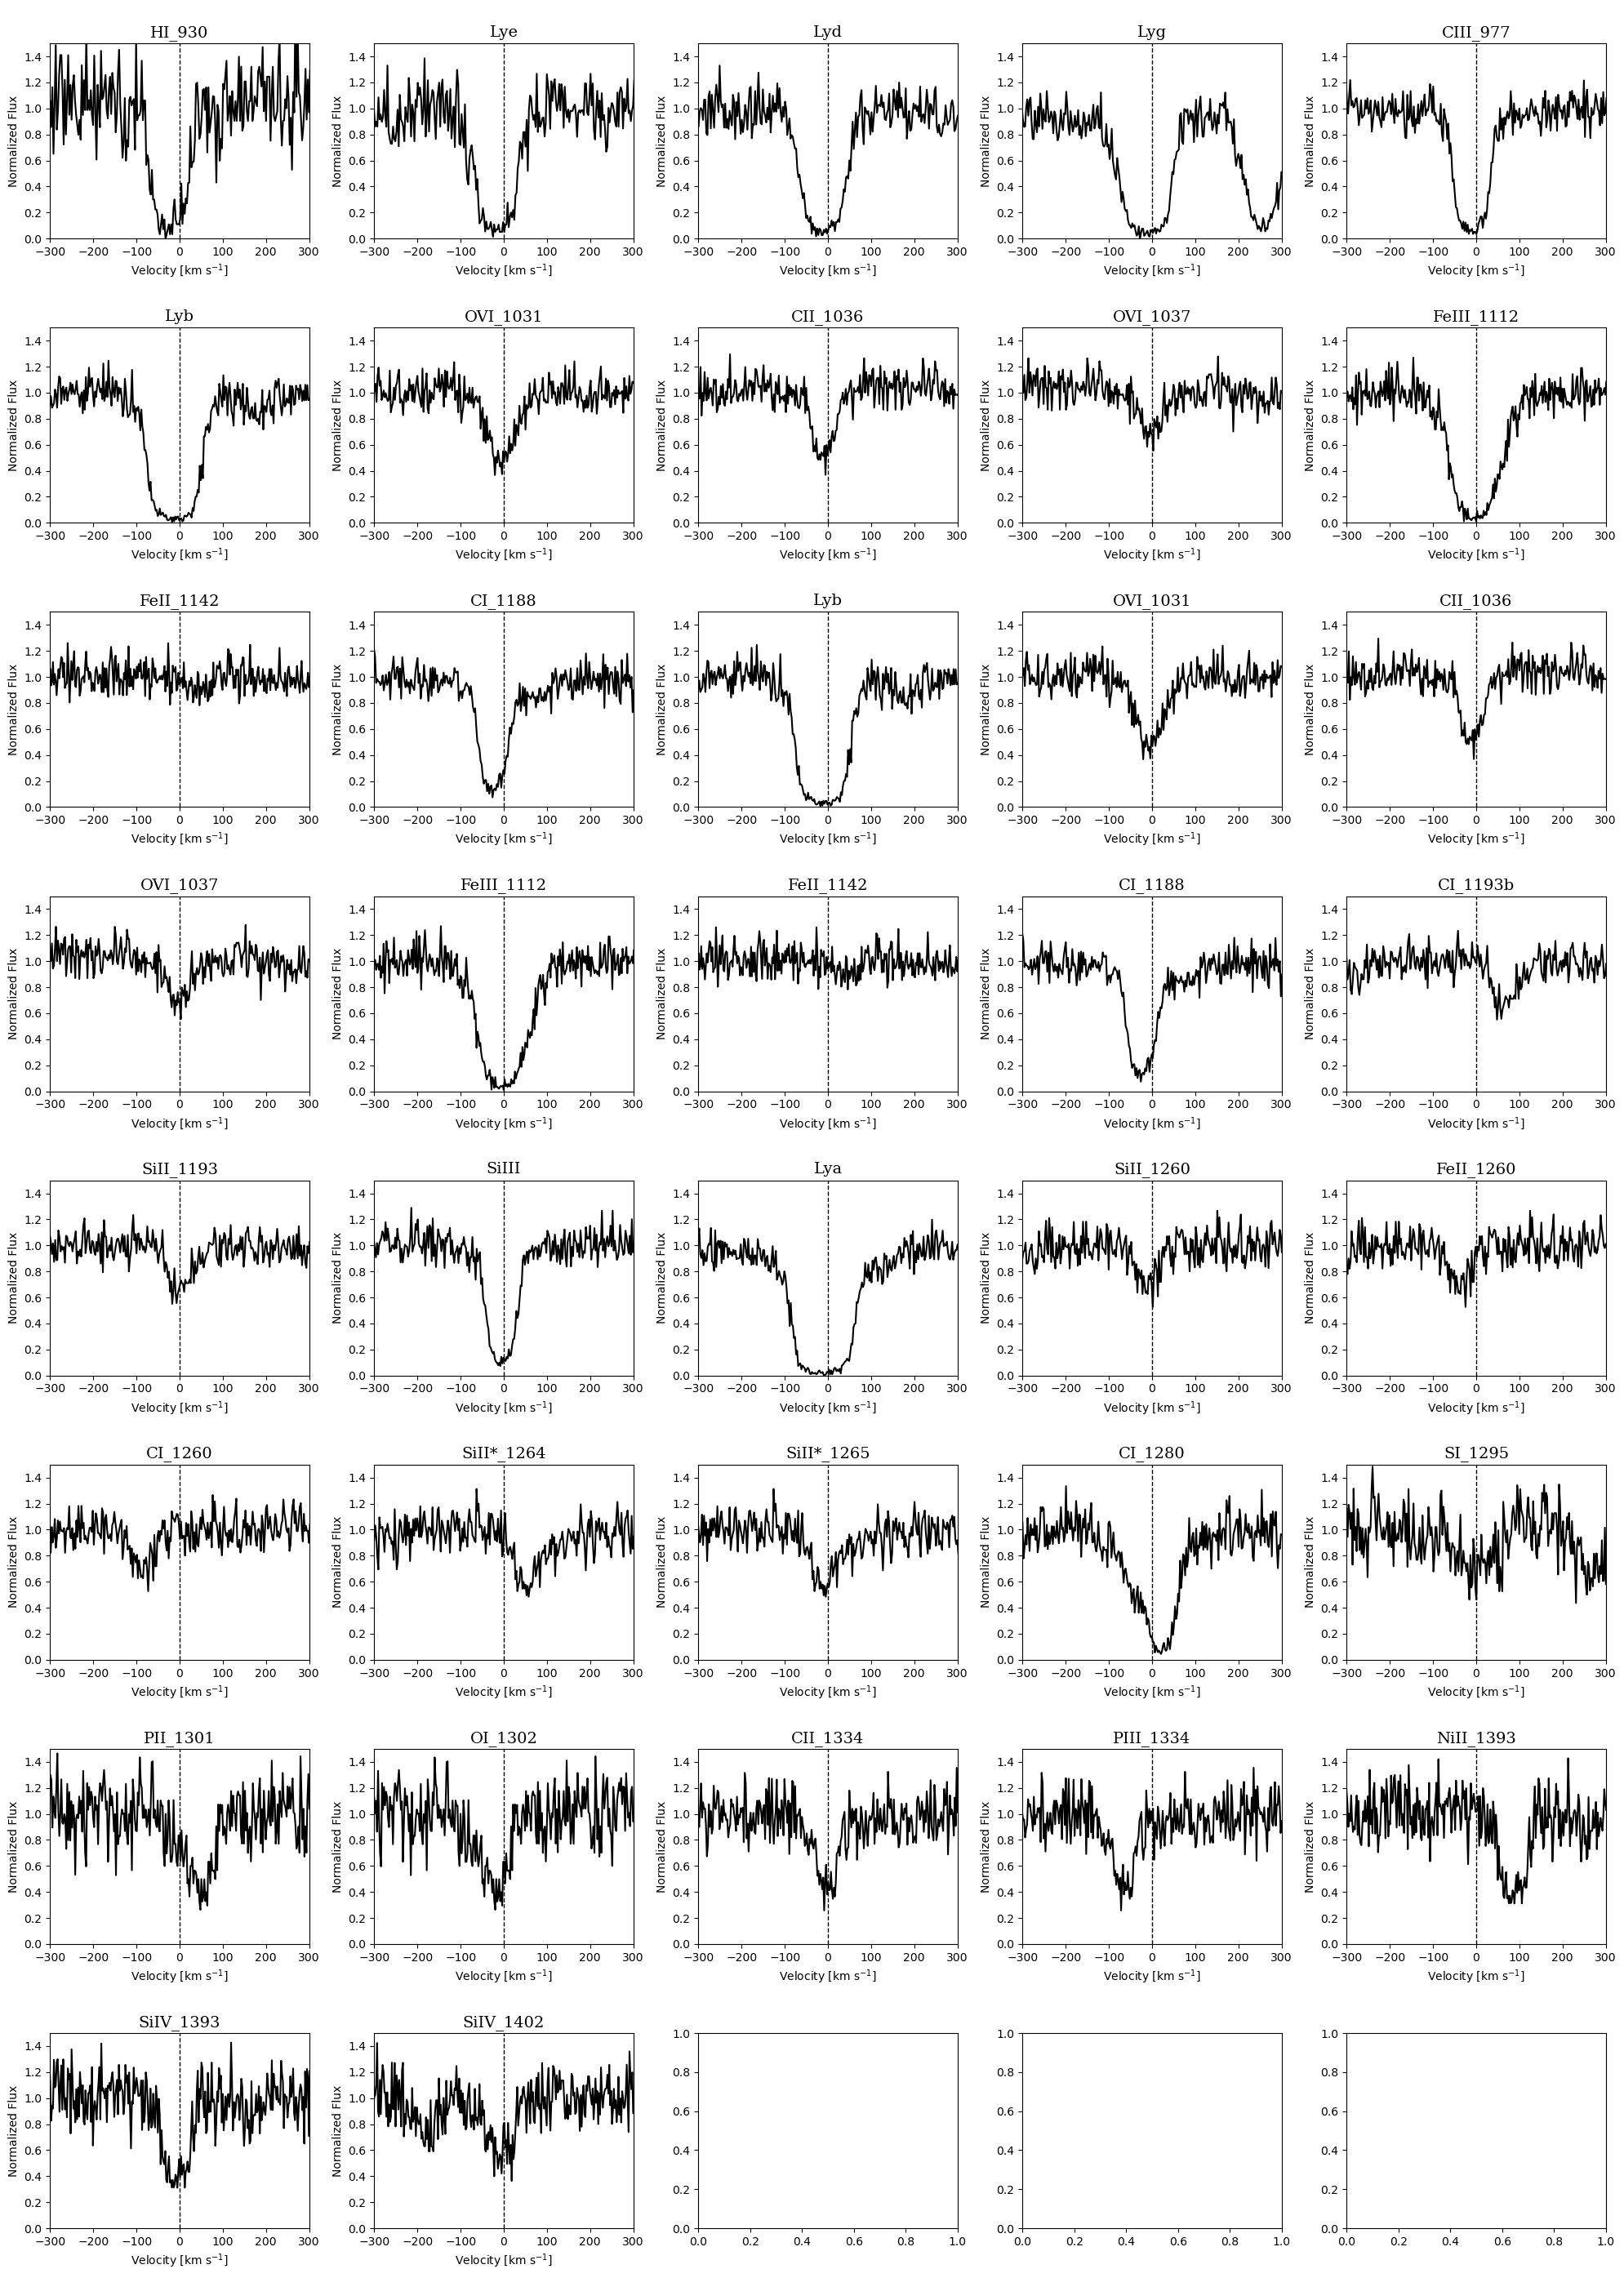

In [22]:
nrows, ncols = 8, 5
fig, axes = plt.subplots(nrows = nrows, ncols=ncols, figsize=(4*ncols, 3.5*nrows))

j = 1
for _, row in valid_lines_data.iterrows():

    plt.subplot(nrows, ncols, j)
    wl_obs = row['wl']*(1+zabs)
    window = 1
    if show_line(wl_obs, window):#, in_velocity=False):
        valid_lines.append(row)
    
    # b, gamma = fit_profile(wl, w=400)
    # print(f'b: {b[0]:.0f} ± {b[1]:.0f}, gamma: {gamma:.2f}')
    # plt.text(-350, 0.1, f'{row[0]} $\lambda${row[1]:.0f}',fontsize=14, fontdict={'family': 'serif'})

    plt.title(f'\n{row["Line"]}',fontsize=14, fontdict={'family': 'serif'})

    plt.ylim(0, 1.5)
    j += 1

fig.tight_layout()
plt.show()

# Fit Voigt Profiles..?